In [1]:
# Cell 1: Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import random
import time
import kornia

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()


print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

All libraries imported successfully!
PyTorch version: 2.5.1
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060


In [2]:
# Cell 2: Model Definitions
print("Defining model architectures...")

class Block(nn.Module):
    def __init__(self, in_channels, filter_size, strides, kernel=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, filter_size, kernel, strides, kernel//2),
            nn.BatchNorm2d(filter_size),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.model(x)

class Encoder(nn.Module):    
    def __init__(self, in_channels=2, out_channels=48, constant_feature_map=48):
        super().__init__()
        self.model = nn.Sequential(
            Block(in_channels, constant_feature_map, 1),
            Block(constant_feature_map, constant_feature_map, 2),
            Block(constant_feature_map, constant_feature_map, 1),
            Block(constant_feature_map, constant_feature_map, 2),
            Block(constant_feature_map, out_channels, 1)
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):        
    def __init__(self, in_channels=48, out_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(64, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(16, out_channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, encoder_constant_features=48):
        super().__init__()
        self.encoder = Encoder(in_channels, encoder_constant_features, encoder_constant_features)
        self.decoder = Decoder(encoder_constant_features, out_channels)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        return self.model(x)

print("Model architectures defined successfully!")
print(f"Generator parameters: {sum(p.numel() for p in Generator().parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in Discriminator().parameters()):,}")

Defining model architectures...
Model architectures defined successfully!
Generator parameters: 298,385
Discriminator parameters: 2,756,801


In [3]:
# Cell 3: Dataset Class - UPDATED for CT-MRI dataset structure
print("Defining CT-MRI Dataset class...")

class CTMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None, img_size=(256, 256)):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.img_size = img_size

        # Find all image pairs
        self.image_pairs = []

        print(f"Scanning dataset directory: {root_dir}")

        # Simple structure: root_dir/CT/ and root_dir/MRI/
        ct_dir = self.root_dir / 'CT'
        mri_dir = self.root_dir / 'MRI'

        # Check if both directories exist
        if ct_dir.exists() and mri_dir.exists():
            print("Found CT and MRI directories")

            # Get all PNG files from both directories
            ct_files = sorted(list(ct_dir.glob('*.png')))
            mri_files = sorted(list(mri_dir.glob('*.png')))

            print(f"Found {len(ct_files)} CT images and {len(mri_files)} MRI images")

            # Match files by name (they should have the same names)
            for ct_file in ct_files:
                mri_file = mri_dir / ct_file.name
                if mri_file.exists():
                    self.image_pairs.append((str(ct_file), str(mri_file)))
                else:
                    print(f"Warning: No matching MRI file for {ct_file.name}")

        else:
            print(f"Warning: Missing CT or MRI directory in {root_dir}")
            print(f"Expected: {ct_dir} and {mri_dir}")

        print(f"Found {len(self.image_pairs)} valid image pairs")

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        ct_path, mri_path = self.image_pairs[idx]

        try:
            # Load images
            ct_img = Image.open(ct_path).convert('RGB')
            mri_img = Image.open(mri_path).convert('RGB')

            # Convert to grayscale for fusion
            ct_gray = ct_img.convert('L')
            mri_gray = mri_img.convert('L')

            # Resize images
            ct_gray = ct_gray.resize(self.img_size, Image.Resampling.BILINEAR)
            mri_gray = mri_gray.resize(self.img_size, Image.Resampling.BILINEAR)

            # Convert to tensors and normalize to [-1, 1]
            if self.transform:
                ct_tensor = self.transform(ct_gray)
                mri_tensor = self.transform(mri_gray)
            else:
                ct_tensor = transforms.ToTensor()(ct_gray)
                mri_tensor = transforms.ToTensor()(mri_gray)
                ct_tensor = ct_tensor * 2.0 - 1.0
                mri_tensor = mri_tensor * 2.0 - 1.0

            return ct_tensor, mri_tensor

        except Exception as e:
            print(f"Error loading image pair {ct_path}, {mri_path}: {e}")
            # Return dummy data if there's an error
            dummy_img = torch.rand(1, self.img_size[0], self.img_size[1]) * 2 - 1
            return dummy_img, dummy_img

print("CT-MRI Dataset class defined successfully!")

Defining CT-MRI Dataset class...
CT-MRI Dataset class defined successfully!


In [4]:
# Cell 4: Training Utilities and Trainer Class - UPDATED save_sample_images method
print("Defining training utilities and trainer class...")

# Path configuration - Define early so they're available for class methods
RESULTS_DIR = "results/ddcgan_fusion"
SAMPLES_DIR = f"{RESULTS_DIR}/samples"
PLOTS_DIR = f"{RESULTS_DIR}/plots"
CHECKPOINTS_DIR = "checkpoints/intermediate/ddcgan_fusion"
FINAL_MODELS_DIR = "checkpoints/final/ddcgan_fusion"

def weights_init(m):
    """Initialize network weights"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def gradient_penalty(discriminator, real_samples, fake_samples, device):
    """Calculate gradient penalty for WGAN-GP"""
    batch_size = real_samples.shape[0]
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)
    
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients = gradients.view(gradients.shape[0], -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

class DDcGANTrainer:
    def __init__(self, dataset_path, batch_size=8, lr=0.0002, img_size=(256, 256), device='cuda'):
        self.device = device
        self.batch_size = batch_size
        self.img_size = img_size
        
        print(f"Initializing trainer with batch_size={batch_size}, lr={lr}, img_size={img_size}")
        
        # Data preparation
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
        ])
        
        print("Loading dataset...")
        self.dataset = CTMRIDataset(dataset_path, transform=transform, img_size=img_size)
        self.dataloader = DataLoader(
            self.dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=4,
            pin_memory=True
        )
        
        print("Initializing models...")
        # Initialize models
        self.generator = Generator(in_channels=2, out_channels=1).to(device)
        self.discriminator1 = Discriminator(in_channels=1).to(device)  # Global discriminator
        self.discriminator2 = Discriminator(in_channels=1).to(device)  # Local discriminator
        
        # Apply weight initialization
        self.generator.apply(weights_init)
        self.discriminator1.apply(weights_init)
        self.discriminator2.apply(weights_init)
        
        print("Initializing optimizers...")
        # Optimizers
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        self.d1_optimizer = optim.Adam(self.discriminator1.parameters(), lr=lr, betas=(0.5, 0.999))
        self.d2_optimizer = optim.Adam(self.discriminator2.parameters(), lr=lr, betas=(0.5, 0.999))
        
        # Loss functions
        self.adversarial_loss = nn.MSELoss()
        self.reconstruction_loss = nn.L1Loss()
        
        # Loss weights
        self.lambda_recon = 100.0
        self.lambda_gp = 10.0
        
        # Training history
        self.g_losses = []
        self.d_losses = []
        self.recon_losses = []
        self.g_adv_losses = []
        self.d1_losses = []
        self.d2_losses = []
        self.epoch_times = []
        
        print("Trainer initialized successfully!")
        
    def gradient_loss(self, gen_img, ir_img):
        """Force generator to keep IR edges"""
        gen_grad = kornia.filters.sobel(gen_img)
        ir_grad = kornia.filters.sobel(ir_img)
        return torch.nn.functional.l1_loss(gen_grad, ir_grad)

    def ssim_loss(self, img1, img2):
        """SSIM-based similarity loss"""
        ssim_fn = kornia.losses.SSIMLoss(window_size=11, reduction='mean')
        return ssim_fn(img1, img2)
        
    def train_epoch(self, epoch):
        start_time = time.time()
        self.generator.train()
        self.discriminator1.train()
        self.discriminator2.train()
        
        epoch_g_loss = 0
        epoch_d_loss = 0
        epoch_recon_loss = 0
        epoch_g_adv_loss = 0
        epoch_d1_loss = 0
        epoch_d2_loss = 0
        epoch_ir_loss = 0
        epoch_ssim_loss = 0

        
        pbar = tqdm(self.dataloader, desc=f'Epoch {epoch}')
        
        for i, (ct_imgs, mri_imgs) in enumerate(pbar):
            batch_size = ct_imgs.size(0)
            ct_imgs = ct_imgs.to(self.device)
            mri_imgs = mri_imgs.to(self.device)
            
            # Concatenate CT and MRI images as input
            input_imgs = torch.cat([ct_imgs, mri_imgs], dim=1)
            
            # Real and fake labels
            real_label = torch.ones(batch_size, 1).to(self.device)
            fake_label = torch.zeros(batch_size, 1).to(self.device)
            
            # ---------------------
            # Train Discriminators
            # ---------------------
            
            # Generate fake fused images
            with torch.no_grad():
                fake_fused = self.generator(input_imgs)
            
            # Create "real" fused images (using CT as reference for now)
            real_fused = ct_imgs
            
            # Train Discriminator 1 (Global)
            self.d1_optimizer.zero_grad()
            
            real_pred1 = self.discriminator1(real_fused)
            fake_pred1 = self.discriminator1(fake_fused.detach())
            
            d1_real_loss = self.adversarial_loss(real_pred1, real_label)
            d1_fake_loss = self.adversarial_loss(fake_pred1, fake_label)
            d1_loss = (d1_real_loss + d1_fake_loss) / 2
            
            d1_loss.backward()
            self.d1_optimizer.step()
            
            # Train Discriminator 2 (Local/Detail)
            self.d2_optimizer.zero_grad()
            
            real_pred2 = self.discriminator2(real_fused)
            fake_pred2 = self.discriminator2(fake_fused.detach())
            
            d2_real_loss = self.adversarial_loss(real_pred2, real_label)
            d2_fake_loss = self.adversarial_loss(fake_pred2, fake_label)
            d2_loss = (d2_real_loss + d2_fake_loss) / 2
            
            d2_loss.backward()
            self.d2_optimizer.step()
            
            total_d_loss = d1_loss + d2_loss
            
            # -----------------
            # Train Generator
            # -----------------
            
            self.g_optimizer.zero_grad()
            
            # Generate fused images
            fused_imgs = self.generator(input_imgs)
            
            # Adversarial losses
            pred1 = self.discriminator1(fused_imgs)
            pred2 = self.discriminator2(fused_imgs)
            
            g_adv_loss1 = self.adversarial_loss(pred1, real_label)
            g_adv_loss2 = self.adversarial_loss(pred2, real_label)
            g_adv_loss = (g_adv_loss1 + g_adv_loss2) / 2
            
            # Reconstruction loss (preserve CT + MRI equally)
            g_recon_loss = self.reconstruction_loss(fused_imgs, ct_imgs) + \
                           self.reconstruction_loss(fused_imgs, mri_imgs)
            
            # MRI gradient-preserving loss
            g_ir_loss = self.gradient_loss(fused_imgs, mri_imgs)
            
            # SSIM loss (structural preservation)
            g_ssim_loss = self.ssim_loss(fused_imgs, ct_imgs) + \
                          self.ssim_loss(fused_imgs, mri_imgs)
            
            # Total generator loss with weights
            g_loss = g_adv_loss + \
                     10.0 * g_recon_loss + \
                     5.0 * g_ir_loss + \
                     1.0 * g_ssim_loss

            
            g_loss.backward()
            self.g_optimizer.step()
            
            # Update losses
            epoch_g_loss += g_loss.item()
            epoch_d_loss += total_d_loss.item()
            epoch_recon_loss += g_recon_loss.item()
            epoch_g_adv_loss += g_adv_loss.item()
            epoch_ir_loss += g_ir_loss.item()
            epoch_ssim_loss += g_ssim_loss.item()
            epoch_d1_loss += d1_loss.item()
            epoch_d2_loss += d2_loss.item()
            
            # Update progress bar
            pbar.set_postfix({
                'G_Loss': f'{g_loss.item():.4f}',
                'D_Loss': f'{total_d_loss.item():.4f}',
                'Recon_Loss': f'{g_recon_loss.item():.4f}',
                'G_Adv_Loss': f'{g_adv_loss.item():.4f}',
                'D1_Loss': f'{d1_loss.item():.4f}',
                'D2_Loss': f'{d2_loss.item():.4f}'
            })
            
            # Save sample images every 100 batches
            if i % 100 == 0:
                self.save_sample_images(ct_imgs, mri_imgs, fused_imgs, epoch, i)
        
        # Calculate epoch averages
        avg_g_loss = epoch_g_loss / len(self.dataloader)
        avg_d_loss = epoch_d_loss / len(self.dataloader)
        avg_recon_loss = epoch_recon_loss / len(self.dataloader)
        avg_g_adv_loss = epoch_g_adv_loss / len(self.dataloader)
        avg_ir_loss = epoch_ir_loss / len(self.dataloader)
        avg_ssim_loss = epoch_ssim_loss / len(self.dataloader)
        avg_d1_loss = epoch_d1_loss / len(self.dataloader)
        avg_d2_loss = epoch_d2_loss / len(self.dataloader)
        epoch_time = time.time() - start_time
        
        # Store metrics
        self.g_losses.append(avg_g_loss)
        self.d_losses.append(avg_d_loss)
        self.recon_losses.append(avg_recon_loss)
        self.g_adv_losses.append(avg_g_adv_loss)
        self.d1_losses.append(avg_d1_loss)
        self.d2_losses.append(avg_d2_loss)
        self.epoch_times.append(epoch_time)
        
        # Print epoch summary
        print(f"\nEpoch {epoch} Summary:")
        print(f"  Generator Loss: {avg_g_loss:.4f}")
        print(f"  Discriminator Loss: {avg_d_loss:.4f}")
        print(f"  Reconstruction Loss: {avg_recon_loss:.4f}")
        print(f"  Generator Adversarial Loss: {avg_g_adv_loss:.4f}")
        print(f"  Discriminator 1 Loss: {avg_d1_loss:.4f}")
        print(f"  Discriminator 2 Loss: {avg_d2_loss:.4f}")
        print(f"  Epoch Time: {epoch_time:.2f} seconds")
        print(f"  MRI Loss: {avg_ir_loss:.4f}")
        print(f"  SSIM Loss: {avg_ssim_loss:.4f}")

        
        return avg_g_loss, avg_d_loss
    
    def save_sample_images(self, ct_imgs, mri_imgs, fused_imgs, epoch, batch_idx):
        """Save sample images during training"""
        os.makedirs(SAMPLES_DIR, exist_ok=True)
        
        # Take first image from batch
        ct_sample = ct_imgs[0].cpu()
        mri_sample = mri_imgs[0].cpu()
        fused_sample = fused_imgs[0].cpu()
        
        # Denormalize images and convert to numpy
        ct_sample = (ct_sample + 1) / 2
        mri_sample = (mri_sample + 1) / 2
        fused_sample = (fused_sample + 1) / 2
        
        # Convert to numpy arrays and ensure proper shape
        ct_np = ct_sample.squeeze().detach().cpu().numpy()
        mri_np = mri_sample.squeeze().detach().cpu().numpy()
        fused_np = fused_sample.squeeze().detach().cpu().numpy()
        
        # Ensure 2D arrays for grayscale
        if len(ct_np.shape) == 3 and ct_np.shape[0] == 1:
            ct_np = ct_np[0]
        if len(mri_np.shape) == 3 and mri_np.shape[0] == 1:
            mri_np = mri_np[0]
        if len(fused_np.shape) == 3 and fused_np.shape[0] == 1:
            fused_np = fused_np[0]
        
        # Create comparison plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(ct_np, cmap='gray')
        axes[0].set_title('CT')
        axes[0].axis('off')
        
        axes[1].imshow(mri_np, cmap='gray')
        axes[1].set_title('MRI')
        axes[1].axis('off')
        
        axes[2].imshow(fused_np, cmap='gray')
        axes[2].set_title('Fused')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{SAMPLES_DIR}/epoch_{epoch}_batch_{batch_idx}.png', dpi=150, bbox_inches='tight')
        plt.close()
    
    def save_model(self, epoch, path=CHECKPOINTS_DIR):
        """Save model checkpoints"""
        os.makedirs(path, exist_ok=True)
        
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator1_state_dict': self.discriminator1.state_dict(),
            'discriminator2_state_dict': self.discriminator2.state_dict(),
            'g_optimizer_state_dict': self.g_optimizer.state_dict(),
            'd1_optimizer_state_dict': self.d1_optimizer.state_dict(),
            'd2_optimizer_state_dict': self.d2_optimizer.state_dict(),
            'g_losses': self.g_losses,
            'd_losses': self.d_losses,
            'recon_losses': self.recon_losses,
            'g_adv_losses': self.g_adv_losses,
            'd1_losses': self.d1_losses,
            'd2_losses': self.d2_losses,
            'epoch_times': self.epoch_times
        }
        
        torch.save(checkpoint, f'{path}/ddcgan_epoch_{epoch}.pth')
        print(f'Model saved at epoch {epoch}')
    
    def load_model(self, checkpoint_path):
        """Load model checkpoint"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator1.load_state_dict(checkpoint['discriminator1_state_dict'])
        self.discriminator2.load_state_dict(checkpoint['discriminator2_state_dict'])
        
        self.g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        self.d1_optimizer.load_state_dict(checkpoint['d1_optimizer_state_dict'])
        self.d2_optimizer.load_state_dict(checkpoint['d2_optimizer_state_dict'])
        
        self.g_losses = checkpoint['g_losses']
        self.d_losses = checkpoint['d_losses']
        self.recon_losses = checkpoint['recon_losses']
        self.g_adv_losses = checkpoint['g_adv_losses']
        self.d1_losses = checkpoint['d1_losses']
        self.d2_losses = checkpoint['d2_losses']
        self.epoch_times = checkpoint['epoch_times']
        
        return checkpoint['epoch']
    
    def train(self, num_epochs, save_interval=5):
        """Main training loop"""
        print(f"Starting training for {num_epochs} epochs...")
        print(f"Dataset size: {len(self.dataset)} image pairs")
        print(f"Batch size: {self.batch_size}")
        print(f"Device: {self.device}")
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            g_loss, d_loss = self.train_epoch(epoch + 1)
            
            print(f'Epoch [{epoch+1}/{num_epochs}] - G_Loss: {g_loss:.4f}, D_Loss: {d_loss:.4f}')
            
            # Save model checkpoint
            if (epoch + 1) % save_interval == 0:
                self.save_model(epoch + 1)
        
        total_time = time.time() - start_time
        print(f"Training completed in {total_time:.2f} seconds!")
        
        # Plot training losses
        self.plot_training_metrics()
    
    def plot_training_metrics(self):
        """Plot all training metrics"""
        os.makedirs(PLOTS_DIR, exist_ok=True)
        
        epochs = range(1, len(self.g_losses) + 1)
        
        # Plot 1: Generator and Discriminator losses
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.g_losses, label='Generator Loss')
        plt.plot(epochs, self.d_losses, label='Discriminator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Generator vs Discriminator Loss')
        
        # Plot 2: Component losses
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.recon_losses, label='Reconstruction Loss')
        plt.plot(epochs, self.g_adv_losses, label='Generator Adv Loss')
        plt.plot(epochs, self.d1_losses, label='Discriminator 1 Loss')
        plt.plot(epochs, self.d2_losses, label='Discriminator 2 Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Component Losses')
        
        plt.tight_layout()
        plt.savefig(f'{PLOTS_DIR}/training_losses.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Plot 3: Epoch times
        plt.figure(figsize=(8, 4))
        plt.plot(epochs, self.epoch_times)
        plt.xlabel('Epoch')
        plt.ylabel('Time (seconds)')
        plt.title('Epoch Training Time')
        plt.savefig(f'{PLOTS_DIR}/epoch_times.png', dpi=150, bbox_inches='tight')
        plt.show()

print("Training utilities and trainer class defined successfully!")

Defining training utilities and trainer class...
Training utilities and trainer class defined successfully!


In [5]:
# Cell 5: Dataset Preparation and Setup - UPDATED configuration
print("Setting up dataset and training configuration...")

# Configuration - Updated for CT-MRI dataset
BATCH_SIZE = 16  # Increased since we have more data
LEARNING_RATE = 0.0002
NUM_EPOCHS = 50
IMG_SIZE = (256, 256)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATASET_PATH = "../Dataset/train"

# Create necessary directories (paths already defined in Cell 4)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(SAMPLES_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
os.makedirs(FINAL_MODELS_DIR, exist_ok=True)

print(f"Using device: {DEVICE}")
print(f"Dataset path: {DATASET_PATH}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Samples directory: {SAMPLES_DIR}")
print(f"Plots directory: {PLOTS_DIR}")
print(f"Checkpoints directory: {CHECKPOINTS_DIR}")
print(f"Final models directory: {FINAL_MODELS_DIR}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Image size: {IMG_SIZE}")

Setting up dataset and training configuration...
Using device: cuda
Dataset path: ../Dataset/train
Results directory: results/ddcgan_fusion
Samples directory: results/ddcgan_fusion/samples
Plots directory: results/ddcgan_fusion/plots
Checkpoints directory: checkpoints/intermediate/ddcgan_fusion
Final models directory: checkpoints/final/ddcgan_fusion
Batch size: 16
Learning rate: 0.0002
Number of epochs: 50
Image size: (256, 256)


Starting model training...
Initializing trainer with batch_size=16, lr=0.0002, img_size=(256, 256)
Loading dataset...
Scanning dataset directory: ../Dataset/train
Found CT and MRI directories
Found 400 CT images and 400 MRI images
Found 400 valid image pairs
Initializing models...
Initializing optimizers...
Trainer initialized successfully!
Trainer created successfully. Starting training...
Starting training for 50 epochs...
Dataset size: 400 image pairs
Batch size: 16
Device: cuda


Epoch 1: 100%|██████████| 25/25 [00:08<00:00,  2.87it/s, G_Loss=10.2263, D_Loss=0.2712, Recon_Loss=0.8391, G_Adv_Loss=0.9585, D1_Loss=0.0533, D2_Loss=0.2179]



Epoch 1 Summary:
  Generator Loss: 12.2379
  Discriminator Loss: 0.2817
  Reconstruction Loss: 1.0542
  Generator Adversarial Loss: 0.6790
  Discriminator 1 Loss: 0.1662
  Discriminator 2 Loss: 0.1155
  Epoch Time: 8.73 seconds
  MRI Loss: 0.0449
  SSIM Loss: 0.7926
Epoch [1/50] - G_Loss: 12.2379, D_Loss: 0.2817


Epoch 2: 100%|██████████| 25/25 [00:08<00:00,  2.99it/s, G_Loss=7.8506, D_Loss=0.0697, Recon_Loss=0.6340, G_Adv_Loss=0.6913, D1_Loss=0.0560, D2_Loss=0.0137]



Epoch 2 Summary:
  Generator Loss: 8.8155
  Discriminator Loss: 0.1293
  Reconstruction Loss: 0.7217
  Generator Adversarial Loss: 0.7739
  Discriminator 1 Loss: 0.0898
  Discriminator 2 Loss: 0.0395
  Epoch Time: 8.35 seconds
  MRI Loss: 0.0452
  SSIM Loss: 0.5982
Epoch [2/50] - G_Loss: 8.8155, D_Loss: 0.1293


Epoch 3: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s, G_Loss=5.9924, D_Loss=0.5778, Recon_Loss=0.4935, G_Adv_Loss=0.2982, D1_Loss=0.3000, D2_Loss=0.2778]



Epoch 3 Summary:
  Generator Loss: 7.2049
  Discriminator Loss: 0.1784
  Reconstruction Loss: 0.5737
  Generator Adversarial Loss: 0.7023
  Discriminator 1 Loss: 0.0717
  Discriminator 2 Loss: 0.1067
  Epoch Time: 8.49 seconds
  MRI Loss: 0.0474
  SSIM Loss: 0.5283
Epoch [3/50] - G_Loss: 7.2049, D_Loss: 0.1784


Epoch 4: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s, G_Loss=6.0260, D_Loss=0.1545, Recon_Loss=0.4878, G_Adv_Loss=0.3874, D1_Loss=0.0693, D2_Loss=0.0852]



Epoch 4 Summary:
  Generator Loss: 6.2800
  Discriminator Loss: 0.2681
  Reconstruction Loss: 0.5011
  Generator Adversarial Loss: 0.5355
  Discriminator 1 Loss: 0.1299
  Discriminator 2 Loss: 0.1382
  Epoch Time: 8.44 seconds
  MRI Loss: 0.0480
  SSIM Loss: 0.4935
Epoch [4/50] - G_Loss: 6.2800, D_Loss: 0.2681


Epoch 5: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s, G_Loss=5.6534, D_Loss=0.2821, Recon_Loss=0.4510, G_Adv_Loss=0.4441, D1_Loss=0.1728, D2_Loss=0.1093]



Epoch 5 Summary:
  Generator Loss: 5.8200
  Discriminator Loss: 0.2874
  Reconstruction Loss: 0.4583
  Generator Adversarial Loss: 0.5284
  Discriminator 1 Loss: 0.1536
  Discriminator 2 Loss: 0.1338
  Epoch Time: 8.49 seconds
  MRI Loss: 0.0490
  SSIM Loss: 0.4636
Epoch [5/50] - G_Loss: 5.8200, D_Loss: 0.2874


Epoch 6: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s, G_Loss=6.1074, D_Loss=0.3648, Recon_Loss=0.4746, G_Adv_Loss=0.5815, D1_Loss=0.1551, D2_Loss=0.2097]



Epoch 6 Summary:
  Generator Loss: 5.6409
  Discriminator Loss: 0.3104
  Reconstruction Loss: 0.4426
  Generator Adversarial Loss: 0.5029
  Discriminator 1 Loss: 0.1489
  Discriminator 2 Loss: 0.1615
  Epoch Time: 8.53 seconds
  MRI Loss: 0.0507
  SSIM Loss: 0.4582
Epoch [6/50] - G_Loss: 5.6409, D_Loss: 0.3104


Epoch 7: 100%|██████████| 25/25 [00:08<00:00,  2.89it/s, G_Loss=5.5416, D_Loss=0.2692, Recon_Loss=0.4157, G_Adv_Loss=0.6896, D1_Loss=0.1361, D2_Loss=0.1331]



Epoch 7 Summary:
  Generator Loss: 5.4424
  Discriminator Loss: 0.3234
  Reconstruction Loss: 0.4246
  Generator Adversarial Loss: 0.4921
  Discriminator 1 Loss: 0.1699
  Discriminator 2 Loss: 0.1535
  Epoch Time: 8.66 seconds
  MRI Loss: 0.0519
  SSIM Loss: 0.4452
Epoch [7/50] - G_Loss: 5.4424, D_Loss: 0.3234


Epoch 8: 100%|██████████| 25/25 [00:08<00:00,  2.90it/s, G_Loss=5.0515, D_Loss=0.4956, Recon_Loss=0.3992, G_Adv_Loss=0.3776, D1_Loss=0.1820, D2_Loss=0.3136]



Epoch 8 Summary:
  Generator Loss: 5.3222
  Discriminator Loss: 0.3419
  Reconstruction Loss: 0.4172
  Generator Adversarial Loss: 0.4415
  Discriminator 1 Loss: 0.1720
  Discriminator 2 Loss: 0.1699
  Epoch Time: 8.64 seconds
  MRI Loss: 0.0535
  SSIM Loss: 0.4415
Epoch [8/50] - G_Loss: 5.3222, D_Loss: 0.3419


Epoch 9: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s, G_Loss=4.9660, D_Loss=0.3499, Recon_Loss=0.4024, G_Adv_Loss=0.2429, D1_Loss=0.1370, D2_Loss=0.2128]



Epoch 9 Summary:
  Generator Loss: 5.1942
  Discriminator Loss: 0.3695
  Reconstruction Loss: 0.4063
  Generator Adversarial Loss: 0.4314
  Discriminator 1 Loss: 0.1806
  Discriminator 2 Loss: 0.1889
  Epoch Time: 8.51 seconds
  MRI Loss: 0.0523
  SSIM Loss: 0.4385
Epoch [9/50] - G_Loss: 5.1942, D_Loss: 0.3695


Epoch 10: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s, G_Loss=5.1490, D_Loss=0.4022, Recon_Loss=0.4040, G_Adv_Loss=0.3614, D1_Loss=0.2106, D2_Loss=0.1916]



Epoch 10 Summary:
  Generator Loss: 5.1325
  Discriminator Loss: 0.3862
  Reconstruction Loss: 0.4041
  Generator Adversarial Loss: 0.3951
  Discriminator 1 Loss: 0.1956
  Discriminator 2 Loss: 0.1906
  Epoch Time: 8.42 seconds
  MRI Loss: 0.0528
  SSIM Loss: 0.4327
Epoch [10/50] - G_Loss: 5.1325, D_Loss: 0.3862
Model saved at epoch 10


Epoch 11: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s, G_Loss=5.1992, D_Loss=0.4452, Recon_Loss=0.4194, G_Adv_Loss=0.2778, D1_Loss=0.2228, D2_Loss=0.2224]



Epoch 11 Summary:
  Generator Loss: 5.1522
  Discriminator Loss: 0.3970
  Reconstruction Loss: 0.4033
  Generator Adversarial Loss: 0.4142
  Discriminator 1 Loss: 0.2121
  Discriminator 2 Loss: 0.1850
  Epoch Time: 8.41 seconds
  MRI Loss: 0.0539
  SSIM Loss: 0.4354
Epoch [11/50] - G_Loss: 5.1522, D_Loss: 0.3970


Epoch 12: 100%|██████████| 25/25 [00:08<00:00,  2.98it/s, G_Loss=4.9967, D_Loss=0.3274, Recon_Loss=0.3883, G_Adv_Loss=0.4935, D1_Loss=0.1257, D2_Loss=0.2016]



Epoch 12 Summary:
  Generator Loss: 5.0747
  Discriminator Loss: 0.4167
  Reconstruction Loss: 0.4006
  Generator Adversarial Loss: 0.3727
  Discriminator 1 Loss: 0.1977
  Discriminator 2 Loss: 0.2190
  Epoch Time: 8.40 seconds
  MRI Loss: 0.0523
  SSIM Loss: 0.4345
Epoch [12/50] - G_Loss: 5.0747, D_Loss: 0.4167


Epoch 13: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s, G_Loss=5.3605, D_Loss=0.4697, Recon_Loss=0.4308, G_Adv_Loss=0.3356, D1_Loss=0.2335, D2_Loss=0.2362]



Epoch 13 Summary:
  Generator Loss: 5.0303
  Discriminator Loss: 0.4027
  Reconstruction Loss: 0.3978
  Generator Adversarial Loss: 0.3756
  Discriminator 1 Loss: 0.1995
  Discriminator 2 Loss: 0.2032
  Epoch Time: 8.47 seconds
  MRI Loss: 0.0501
  SSIM Loss: 0.4268
Epoch [13/50] - G_Loss: 5.0303, D_Loss: 0.4027


Epoch 14: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s, G_Loss=5.1765, D_Loss=0.4330, Recon_Loss=0.4095, G_Adv_Loss=0.3453, D1_Loss=0.1872, D2_Loss=0.2459]



Epoch 14 Summary:
  Generator Loss: 5.0227
  Discriminator Loss: 0.3928
  Reconstruction Loss: 0.3964
  Generator Adversarial Loss: 0.3669
  Discriminator 1 Loss: 0.1953
  Discriminator 2 Loss: 0.1976
  Epoch Time: 8.46 seconds
  MRI Loss: 0.0530
  SSIM Loss: 0.4262
Epoch [14/50] - G_Loss: 5.0227, D_Loss: 0.3928


Epoch 15: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s, G_Loss=5.1644, D_Loss=0.4265, Recon_Loss=0.4224, G_Adv_Loss=0.2118, D1_Loss=0.2195, D2_Loss=0.2070]



Epoch 15 Summary:
  Generator Loss: 4.9496
  Discriminator Loss: 0.4200
  Reconstruction Loss: 0.3932
  Generator Adversarial Loss: 0.3431
  Discriminator 1 Loss: 0.2005
  Discriminator 2 Loss: 0.2195
  Epoch Time: 8.42 seconds
  MRI Loss: 0.0503
  SSIM Loss: 0.4223
Epoch [15/50] - G_Loss: 4.9496, D_Loss: 0.4200


Epoch 16: 100%|██████████| 25/25 [00:08<00:00,  2.99it/s, G_Loss=4.8944, D_Loss=0.3750, Recon_Loss=0.3827, G_Adv_Loss=0.4288, D1_Loss=0.2086, D2_Loss=0.1664]



Epoch 16 Summary:
  Generator Loss: 5.0252
  Discriminator Loss: 0.4051
  Reconstruction Loss: 0.3972
  Generator Adversarial Loss: 0.3700
  Discriminator 1 Loss: 0.2040
  Discriminator 2 Loss: 0.2011
  Epoch Time: 8.37 seconds
  MRI Loss: 0.0515
  SSIM Loss: 0.4262
Epoch [16/50] - G_Loss: 5.0252, D_Loss: 0.4051


Epoch 17: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s, G_Loss=4.8016, D_Loss=0.4201, Recon_Loss=0.3703, G_Adv_Loss=0.4374, D1_Loss=0.2088, D2_Loss=0.2113]



Epoch 17 Summary:
  Generator Loss: 4.9499
  Discriminator Loss: 0.4163
  Reconstruction Loss: 0.3927
  Generator Adversarial Loss: 0.3439
  Discriminator 1 Loss: 0.2032
  Discriminator 2 Loss: 0.2131
  Epoch Time: 8.41 seconds
  MRI Loss: 0.0523
  SSIM Loss: 0.4180
Epoch [17/50] - G_Loss: 4.9499, D_Loss: 0.4163


Epoch 18: 100%|██████████| 25/25 [00:08<00:00,  2.98it/s, G_Loss=4.9091, D_Loss=0.3828, Recon_Loss=0.3779, G_Adv_Loss=0.4787, D1_Loss=0.1863, D2_Loss=0.1965]



Epoch 18 Summary:
  Generator Loss: 4.9699
  Discriminator Loss: 0.4194
  Reconstruction Loss: 0.3933
  Generator Adversarial Loss: 0.3500
  Discriminator 1 Loss: 0.2119
  Discriminator 2 Loss: 0.2075
  Epoch Time: 8.38 seconds
  MRI Loss: 0.0530
  SSIM Loss: 0.4223
Epoch [18/50] - G_Loss: 4.9699, D_Loss: 0.4194


Epoch 19: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s, G_Loss=4.7788, D_Loss=0.3676, Recon_Loss=0.3600, G_Adv_Loss=0.5566, D1_Loss=0.1770, D2_Loss=0.1906]



Epoch 19 Summary:
  Generator Loss: 4.9691
  Discriminator Loss: 0.4209
  Reconstruction Loss: 0.3937
  Generator Adversarial Loss: 0.3426
  Discriminator 1 Loss: 0.2081
  Discriminator 2 Loss: 0.2128
  Epoch Time: 8.44 seconds
  MRI Loss: 0.0545
  SSIM Loss: 0.4175
Epoch [19/50] - G_Loss: 4.9691, D_Loss: 0.4209


Epoch 20: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s, G_Loss=4.8580, D_Loss=0.5064, Recon_Loss=0.3824, G_Adv_Loss=0.3474, D1_Loss=0.2423, D2_Loss=0.2641]



Epoch 20 Summary:
  Generator Loss: 4.9639
  Discriminator Loss: 0.4271
  Reconstruction Loss: 0.3944
  Generator Adversarial Loss: 0.3380
  Discriminator 1 Loss: 0.2111
  Discriminator 2 Loss: 0.2161
  Epoch Time: 8.44 seconds
  MRI Loss: 0.0520
  SSIM Loss: 0.4213
Epoch [20/50] - G_Loss: 4.9639, D_Loss: 0.4271
Model saved at epoch 20


Epoch 21: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s, G_Loss=4.5479, D_Loss=0.4351, Recon_Loss=0.3587, G_Adv_Loss=0.3075, D1_Loss=0.2184, D2_Loss=0.2167]



Epoch 21 Summary:
  Generator Loss: 4.9431
  Discriminator Loss: 0.4266
  Reconstruction Loss: 0.3921
  Generator Adversarial Loss: 0.3368
  Discriminator 1 Loss: 0.2155
  Discriminator 2 Loss: 0.2111
  Epoch Time: 8.42 seconds
  MRI Loss: 0.0537
  SSIM Loss: 0.4167
Epoch [21/50] - G_Loss: 4.9431, D_Loss: 0.4266


Epoch 22: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s, G_Loss=5.1444, D_Loss=0.4137, Recon_Loss=0.4040, G_Adv_Loss=0.3987, D1_Loss=0.1543, D2_Loss=0.2594]



Epoch 22 Summary:
  Generator Loss: 4.9354
  Discriminator Loss: 0.4215
  Reconstruction Loss: 0.3905
  Generator Adversarial Loss: 0.3474
  Discriminator 1 Loss: 0.2091
  Discriminator 2 Loss: 0.2124
  Epoch Time: 8.46 seconds
  MRI Loss: 0.0540
  SSIM Loss: 0.4128
Epoch [22/50] - G_Loss: 4.9354, D_Loss: 0.4215


Epoch 23: 100%|██████████| 25/25 [00:08<00:00,  2.99it/s, G_Loss=5.2464, D_Loss=0.3739, Recon_Loss=0.4224, G_Adv_Loss=0.2991, D1_Loss=0.1743, D2_Loss=0.1996]



Epoch 23 Summary:
  Generator Loss: 4.9343
  Discriminator Loss: 0.4353
  Reconstruction Loss: 0.3914
  Generator Adversarial Loss: 0.3354
  Discriminator 1 Loss: 0.2095
  Discriminator 2 Loss: 0.2258
  Epoch Time: 8.37 seconds
  MRI Loss: 0.0545
  SSIM Loss: 0.4121
Epoch [23/50] - G_Loss: 4.9343, D_Loss: 0.4353


Epoch 24: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s, G_Loss=4.8839, D_Loss=0.3959, Recon_Loss=0.3914, G_Adv_Loss=0.2562, D1_Loss=0.1875, D2_Loss=0.2083]



Epoch 24 Summary:
  Generator Loss: 4.9287
  Discriminator Loss: 0.4209
  Reconstruction Loss: 0.3909
  Generator Adversarial Loss: 0.3375
  Discriminator 1 Loss: 0.2110
  Discriminator 2 Loss: 0.2098
  Epoch Time: 8.44 seconds
  MRI Loss: 0.0540
  SSIM Loss: 0.4118
Epoch [24/50] - G_Loss: 4.9287, D_Loss: 0.4209


Epoch 25: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s, G_Loss=4.3416, D_Loss=0.4123, Recon_Loss=0.3456, G_Adv_Loss=0.2825, D1_Loss=0.1873, D2_Loss=0.2249]



Epoch 25 Summary:
  Generator Loss: 4.9133
  Discriminator Loss: 0.4311
  Reconstruction Loss: 0.3902
  Generator Adversarial Loss: 0.3243
  Discriminator 1 Loss: 0.2115
  Discriminator 2 Loss: 0.2196
  Epoch Time: 8.43 seconds
  MRI Loss: 0.0566
  SSIM Loss: 0.4038
Epoch [25/50] - G_Loss: 4.9133, D_Loss: 0.4311


Epoch 26: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s, G_Loss=4.4744, D_Loss=0.3850, Recon_Loss=0.3557, G_Adv_Loss=0.2970, D1_Loss=0.1754, D2_Loss=0.2097]



Epoch 26 Summary:
  Generator Loss: 4.9268
  Discriminator Loss: 0.4168
  Reconstruction Loss: 0.3902
  Generator Adversarial Loss: 0.3413
  Discriminator 1 Loss: 0.2043
  Discriminator 2 Loss: 0.2125
  Epoch Time: 8.44 seconds
  MRI Loss: 0.0547
  SSIM Loss: 0.4099
Epoch [26/50] - G_Loss: 4.9268, D_Loss: 0.4168


Epoch 27: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s, G_Loss=6.2419, D_Loss=0.5253, Recon_Loss=0.5119, G_Adv_Loss=0.3062, D1_Loss=0.2274, D2_Loss=0.2979]



Epoch 27 Summary:
  Generator Loss: 4.9746
  Discriminator Loss: 0.4295
  Reconstruction Loss: 0.3946
  Generator Adversarial Loss: 0.3404
  Discriminator 1 Loss: 0.2133
  Discriminator 2 Loss: 0.2162
  Epoch Time: 8.43 seconds
  MRI Loss: 0.0560
  SSIM Loss: 0.4082
Epoch [27/50] - G_Loss: 4.9746, D_Loss: 0.4295


Epoch 28: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s, G_Loss=4.9118, D_Loss=0.5779, Recon_Loss=0.3852, G_Adv_Loss=0.3623, D1_Loss=0.2867, D2_Loss=0.2912]



Epoch 28 Summary:
  Generator Loss: 4.9467
  Discriminator Loss: 0.4283
  Reconstruction Loss: 0.3918
  Generator Adversarial Loss: 0.3417
  Discriminator 1 Loss: 0.2117
  Discriminator 2 Loss: 0.2165
  Epoch Time: 8.54 seconds
  MRI Loss: 0.0557
  SSIM Loss: 0.4088
Epoch [28/50] - G_Loss: 4.9467, D_Loss: 0.4283


Epoch 29: 100%|██████████| 25/25 [00:08<00:00,  3.03it/s, G_Loss=4.4699, D_Loss=0.4119, Recon_Loss=0.3591, G_Adv_Loss=0.2419, D1_Loss=0.1993, D2_Loss=0.2126]



Epoch 29 Summary:
  Generator Loss: 4.8822
  Discriminator Loss: 0.4349
  Reconstruction Loss: 0.3882
  Generator Adversarial Loss: 0.3201
  Discriminator 1 Loss: 0.2164
  Discriminator 2 Loss: 0.2185
  Epoch Time: 8.26 seconds
  MRI Loss: 0.0557
  SSIM Loss: 0.4014
Epoch [29/50] - G_Loss: 4.8822, D_Loss: 0.4349


Epoch 30: 100%|██████████| 25/25 [00:08<00:00,  3.07it/s, G_Loss=4.9638, D_Loss=0.4148, Recon_Loss=0.3938, G_Adv_Loss=0.3551, D1_Loss=0.2007, D2_Loss=0.2140]



Epoch 30 Summary:
  Generator Loss: 4.9262
  Discriminator Loss: 0.4271
  Reconstruction Loss: 0.3907
  Generator Adversarial Loss: 0.3327
  Discriminator 1 Loss: 0.2122
  Discriminator 2 Loss: 0.2149
  Epoch Time: 8.15 seconds
  MRI Loss: 0.0570
  SSIM Loss: 0.4018
Epoch [30/50] - G_Loss: 4.9262, D_Loss: 0.4271
Model saved at epoch 30


Epoch 31: 100%|██████████| 25/25 [00:08<00:00,  3.06it/s, G_Loss=4.5998, D_Loss=0.3875, Recon_Loss=0.3625, G_Adv_Loss=0.3117, D1_Loss=0.1948, D2_Loss=0.1927]



Epoch 31 Summary:
  Generator Loss: 4.8914
  Discriminator Loss: 0.4302
  Reconstruction Loss: 0.3887
  Generator Adversarial Loss: 0.3190
  Discriminator 1 Loss: 0.2086
  Discriminator 2 Loss: 0.2215
  Epoch Time: 8.17 seconds
  MRI Loss: 0.0579
  SSIM Loss: 0.3965
Epoch [31/50] - G_Loss: 4.8914, D_Loss: 0.4302


Epoch 32: 100%|██████████| 25/25 [00:08<00:00,  3.08it/s, G_Loss=4.4021, D_Loss=0.4316, Recon_Loss=0.3481, G_Adv_Loss=0.2823, D1_Loss=0.2149, D2_Loss=0.2167]



Epoch 32 Summary:
  Generator Loss: 4.9423
  Discriminator Loss: 0.4346
  Reconstruction Loss: 0.3917
  Generator Adversarial Loss: 0.3316
  Discriminator 1 Loss: 0.2171
  Discriminator 2 Loss: 0.2175
  Epoch Time: 8.12 seconds
  MRI Loss: 0.0582
  SSIM Loss: 0.4027
Epoch [32/50] - G_Loss: 4.9423, D_Loss: 0.4346


Epoch 33: 100%|██████████| 25/25 [00:08<00:00,  3.05it/s, G_Loss=4.6139, D_Loss=0.4542, Recon_Loss=0.3649, G_Adv_Loss=0.3145, D1_Loss=0.2258, D2_Loss=0.2284]



Epoch 33 Summary:
  Generator Loss: 4.9067
  Discriminator Loss: 0.4322
  Reconstruction Loss: 0.3897
  Generator Adversarial Loss: 0.3202
  Discriminator 1 Loss: 0.2152
  Discriminator 2 Loss: 0.2170
  Epoch Time: 8.20 seconds
  MRI Loss: 0.0584
  SSIM Loss: 0.3970
Epoch [33/50] - G_Loss: 4.9067, D_Loss: 0.4322


Epoch 34: 100%|██████████| 25/25 [00:08<00:00,  3.05it/s, G_Loss=5.1940, D_Loss=0.4036, Recon_Loss=0.4219, G_Adv_Loss=0.3010, D1_Loss=0.2110, D2_Loss=0.1925]



Epoch 34 Summary:
  Generator Loss: 4.8761
  Discriminator Loss: 0.4346
  Reconstruction Loss: 0.3879
  Generator Adversarial Loss: 0.3152
  Discriminator 1 Loss: 0.2106
  Discriminator 2 Loss: 0.2239
  Epoch Time: 8.19 seconds
  MRI Loss: 0.0560
  SSIM Loss: 0.4015
Epoch [34/50] - G_Loss: 4.8761, D_Loss: 0.4346


Epoch 35: 100%|██████████| 25/25 [00:08<00:00,  3.00it/s, G_Loss=4.7680, D_Loss=0.3898, Recon_Loss=0.3706, G_Adv_Loss=0.4088, D1_Loss=0.1961, D2_Loss=0.1936]



Epoch 35 Summary:
  Generator Loss: 4.8639
  Discriminator Loss: 0.4187
  Reconstruction Loss: 0.3863
  Generator Adversarial Loss: 0.3259
  Discriminator 1 Loss: 0.2056
  Discriminator 2 Loss: 0.2131
  Epoch Time: 8.35 seconds
  MRI Loss: 0.0558
  SSIM Loss: 0.3966
Epoch [35/50] - G_Loss: 4.8639, D_Loss: 0.4187


Epoch 36: 100%|██████████| 25/25 [00:08<00:00,  3.06it/s, G_Loss=4.4885, D_Loss=0.4301, Recon_Loss=0.3529, G_Adv_Loss=0.3051, D1_Loss=0.2063, D2_Loss=0.2238]



Epoch 36 Summary:
  Generator Loss: 4.8842
  Discriminator Loss: 0.4371
  Reconstruction Loss: 0.3886
  Generator Adversarial Loss: 0.3104
  Discriminator 1 Loss: 0.2153
  Discriminator 2 Loss: 0.2218
  Epoch Time: 8.17 seconds
  MRI Loss: 0.0596
  SSIM Loss: 0.3900
Epoch [36/50] - G_Loss: 4.8842, D_Loss: 0.4371


Epoch 37: 100%|██████████| 25/25 [00:08<00:00,  3.09it/s, G_Loss=4.4861, D_Loss=0.4669, Recon_Loss=0.3555, G_Adv_Loss=0.3226, D1_Loss=0.2321, D2_Loss=0.2348]



Epoch 37 Summary:
  Generator Loss: 4.9021
  Discriminator Loss: 0.4494
  Reconstruction Loss: 0.3888
  Generator Adversarial Loss: 0.3294
  Discriminator 1 Loss: 0.2192
  Discriminator 2 Loss: 0.2302
  Epoch Time: 8.08 seconds
  MRI Loss: 0.0583
  SSIM Loss: 0.3930
Epoch [37/50] - G_Loss: 4.9021, D_Loss: 0.4494


Epoch 38: 100%|██████████| 25/25 [00:08<00:00,  3.09it/s, G_Loss=5.2579, D_Loss=0.4717, Recon_Loss=0.4168, G_Adv_Loss=0.3395, D1_Loss=0.2511, D2_Loss=0.2205]



Epoch 38 Summary:
  Generator Loss: 4.8799
  Discriminator Loss: 0.4350
  Reconstruction Loss: 0.3877
  Generator Adversarial Loss: 0.3205
  Discriminator 1 Loss: 0.2143
  Discriminator 2 Loss: 0.2207
  Epoch Time: 8.10 seconds
  MRI Loss: 0.0591
  SSIM Loss: 0.3870
Epoch [38/50] - G_Loss: 4.8799, D_Loss: 0.4350


Epoch 39: 100%|██████████| 25/25 [00:08<00:00,  3.08it/s, G_Loss=5.1686, D_Loss=0.4444, Recon_Loss=0.4096, G_Adv_Loss=0.3746, D1_Loss=0.2174, D2_Loss=0.2270]



Epoch 39 Summary:
  Generator Loss: 4.9071
  Discriminator Loss: 0.4315
  Reconstruction Loss: 0.3896
  Generator Adversarial Loss: 0.3253
  Discriminator 1 Loss: 0.2106
  Discriminator 2 Loss: 0.2209
  Epoch Time: 8.13 seconds
  MRI Loss: 0.0599
  SSIM Loss: 0.3859
Epoch [39/50] - G_Loss: 4.9071, D_Loss: 0.4315


Epoch 40: 100%|██████████| 25/25 [00:08<00:00,  3.06it/s, G_Loss=5.0176, D_Loss=0.4544, Recon_Loss=0.4026, G_Adv_Loss=0.2710, D1_Loss=0.1977, D2_Loss=0.2567]



Epoch 40 Summary:
  Generator Loss: 4.9198
  Discriminator Loss: 0.4351
  Reconstruction Loss: 0.3902
  Generator Adversarial Loss: 0.3231
  Discriminator 1 Loss: 0.2101
  Discriminator 2 Loss: 0.2251
  Epoch Time: 8.16 seconds
  MRI Loss: 0.0598
  SSIM Loss: 0.3956
Epoch [40/50] - G_Loss: 4.9198, D_Loss: 0.4351
Model saved at epoch 40


Epoch 41: 100%|██████████| 25/25 [00:08<00:00,  3.08it/s, G_Loss=5.1778, D_Loss=0.4459, Recon_Loss=0.4151, G_Adv_Loss=0.3337, D1_Loss=0.2272, D2_Loss=0.2187]



Epoch 41 Summary:
  Generator Loss: 4.8992
  Discriminator Loss: 0.4647
  Reconstruction Loss: 0.3888
  Generator Adversarial Loss: 0.3281
  Discriminator 1 Loss: 0.2397
  Discriminator 2 Loss: 0.2249
  Epoch Time: 8.12 seconds
  MRI Loss: 0.0594
  SSIM Loss: 0.3859
Epoch [41/50] - G_Loss: 4.8992, D_Loss: 0.4647


Epoch 42: 100%|██████████| 25/25 [00:08<00:00,  3.05it/s, G_Loss=5.1733, D_Loss=0.4041, Recon_Loss=0.4129, G_Adv_Loss=0.2935, D1_Loss=0.1869, D2_Loss=0.2172]



Epoch 42 Summary:
  Generator Loss: 4.9000
  Discriminator Loss: 0.4247
  Reconstruction Loss: 0.3896
  Generator Adversarial Loss: 0.3130
  Discriminator 1 Loss: 0.2108
  Discriminator 2 Loss: 0.2139
  Epoch Time: 8.19 seconds
  MRI Loss: 0.0597
  SSIM Loss: 0.3927
Epoch [42/50] - G_Loss: 4.9000, D_Loss: 0.4247


Epoch 43: 100%|██████████| 25/25 [00:08<00:00,  2.99it/s, G_Loss=4.4257, D_Loss=0.4195, Recon_Loss=0.3422, G_Adv_Loss=0.3450, D1_Loss=0.2167, D2_Loss=0.2028]



Epoch 43 Summary:
  Generator Loss: 4.9126
  Discriminator Loss: 0.4433
  Reconstruction Loss: 0.3905
  Generator Adversarial Loss: 0.3150
  Discriminator 1 Loss: 0.2192
  Discriminator 2 Loss: 0.2241
  Epoch Time: 8.35 seconds
  MRI Loss: 0.0610
  SSIM Loss: 0.3872
Epoch [43/50] - G_Loss: 4.9126, D_Loss: 0.4433


Epoch 44: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s, G_Loss=4.7121, D_Loss=0.4693, Recon_Loss=0.3778, G_Adv_Loss=0.2890, D1_Loss=0.2124, D2_Loss=0.2569]



Epoch 44 Summary:
  Generator Loss: 4.9049
  Discriminator Loss: 0.4416
  Reconstruction Loss: 0.3899
  Generator Adversarial Loss: 0.3164
  Discriminator 1 Loss: 0.2191
  Discriminator 2 Loss: 0.2225
  Epoch Time: 8.47 seconds
  MRI Loss: 0.0609
  SSIM Loss: 0.3856
Epoch [44/50] - G_Loss: 4.9049, D_Loss: 0.4416


Epoch 45: 100%|██████████| 25/25 [00:08<00:00,  2.98it/s, G_Loss=4.5251, D_Loss=0.4516, Recon_Loss=0.3539, G_Adv_Loss=0.3381, D1_Loss=0.2209, D2_Loss=0.2307]



Epoch 45 Summary:
  Generator Loss: 4.9370
  Discriminator Loss: 0.4421
  Reconstruction Loss: 0.3919
  Generator Adversarial Loss: 0.3226
  Discriminator 1 Loss: 0.2204
  Discriminator 2 Loss: 0.2216
  Epoch Time: 8.39 seconds
  MRI Loss: 0.0605
  SSIM Loss: 0.3925
Epoch [45/50] - G_Loss: 4.9370, D_Loss: 0.4421


Epoch 46: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s, G_Loss=4.5871, D_Loss=0.4712, Recon_Loss=0.3661, G_Adv_Loss=0.3138, D1_Loss=0.2510, D2_Loss=0.2202]



Epoch 46 Summary:
  Generator Loss: 4.8981
  Discriminator Loss: 0.4313
  Reconstruction Loss: 0.3895
  Generator Adversarial Loss: 0.3107
  Discriminator 1 Loss: 0.2118
  Discriminator 2 Loss: 0.2195
  Epoch Time: 8.44 seconds
  MRI Loss: 0.0617
  SSIM Loss: 0.3840
Epoch [46/50] - G_Loss: 4.8981, D_Loss: 0.4313


Epoch 47: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s, G_Loss=4.4582, D_Loss=0.4987, Recon_Loss=0.3571, G_Adv_Loss=0.2610, D1_Loss=0.2403, D2_Loss=0.2584]



Epoch 47 Summary:
  Generator Loss: 4.8898
  Discriminator Loss: 0.4343
  Reconstruction Loss: 0.3882
  Generator Adversarial Loss: 0.3209
  Discriminator 1 Loss: 0.2138
  Discriminator 2 Loss: 0.2206
  Epoch Time: 8.42 seconds
  MRI Loss: 0.0586
  SSIM Loss: 0.3933
Epoch [47/50] - G_Loss: 4.8898, D_Loss: 0.4343


Epoch 48: 100%|██████████| 25/25 [00:08<00:00,  2.99it/s, G_Loss=4.5002, D_Loss=0.5340, Recon_Loss=0.3645, G_Adv_Loss=0.2173, D1_Loss=0.2560, D2_Loss=0.2780]



Epoch 48 Summary:
  Generator Loss: 4.8627
  Discriminator Loss: 0.4397
  Reconstruction Loss: 0.3877
  Generator Adversarial Loss: 0.3056
  Discriminator 1 Loss: 0.2167
  Discriminator 2 Loss: 0.2230
  Epoch Time: 8.37 seconds
  MRI Loss: 0.0614
  SSIM Loss: 0.3729
Epoch [48/50] - G_Loss: 4.8627, D_Loss: 0.4397


Epoch 49: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s, G_Loss=4.5619, D_Loss=0.4648, Recon_Loss=0.3718, G_Adv_Loss=0.1992, D1_Loss=0.2318, D2_Loss=0.2329]



Epoch 49 Summary:
  Generator Loss: 4.8938
  Discriminator Loss: 0.4476
  Reconstruction Loss: 0.3897
  Generator Adversarial Loss: 0.3097
  Discriminator 1 Loss: 0.2190
  Discriminator 2 Loss: 0.2286
  Epoch Time: 8.44 seconds
  MRI Loss: 0.0616
  SSIM Loss: 0.3793
Epoch [49/50] - G_Loss: 4.8938, D_Loss: 0.4476


Epoch 50: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s, G_Loss=5.0552, D_Loss=0.4514, Recon_Loss=0.4055, G_Adv_Loss=0.2883, D1_Loss=0.2012, D2_Loss=0.2502]



Epoch 50 Summary:
  Generator Loss: 4.8701
  Discriminator Loss: 0.4577
  Reconstruction Loss: 0.3878
  Generator Adversarial Loss: 0.3077
  Discriminator 1 Loss: 0.2269
  Discriminator 2 Loss: 0.2308
  Epoch Time: 8.50 seconds
  MRI Loss: 0.0612
  SSIM Loss: 0.3782
Epoch [50/50] - G_Loss: 4.8701, D_Loss: 0.4577
Model saved at epoch 50
Training completed in 419.94 seconds!


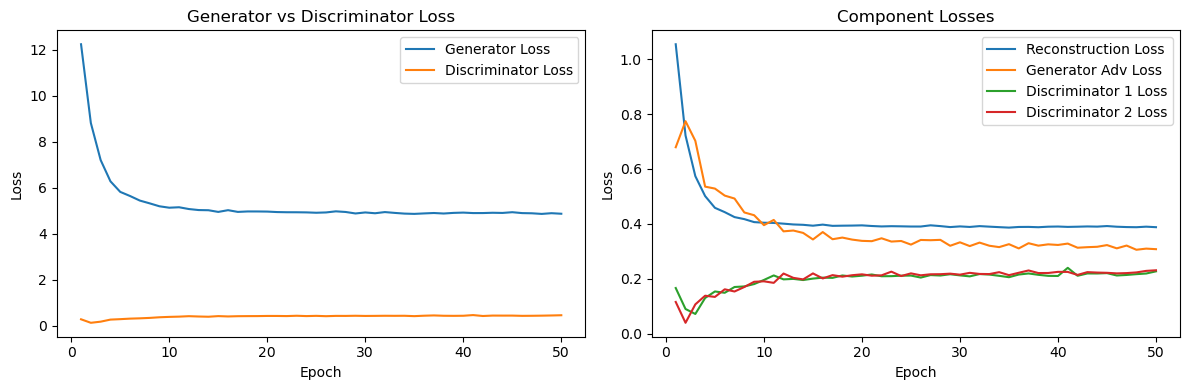

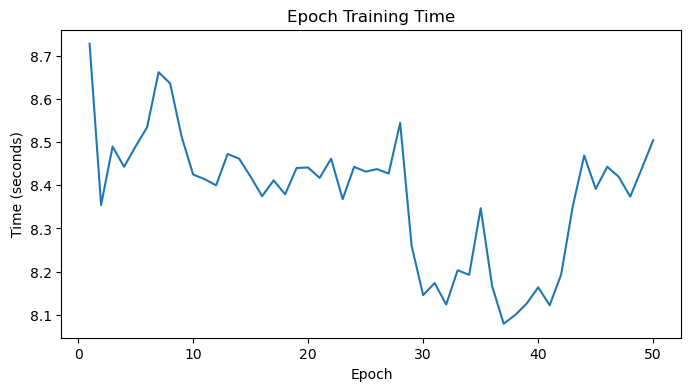

Model saved at epoch 50
Training completed successfully!
Model checkpoints saved in: checkpoints/intermediate/ddcgan_fusion
Final model saved in: checkpoints/final/ddcgan_fusion
Sample images saved in: results/ddcgan_fusion/samples
Training plots saved in: results/ddcgan_fusion/plots


In [6]:
print("Starting model training...")

# Only run if dataset is available
if DATASET_PATH and os.path.exists(DATASET_PATH):
    try:
        # Create trainer
        trainer = DDcGANTrainer(
            dataset_path=DATASET_PATH,
            batch_size=BATCH_SIZE,
            lr=LEARNING_RATE,
            img_size=IMG_SIZE,
            device=DEVICE
        )
        
        print("Trainer created successfully. Starting training...")
        
        # Start training
        trainer.train(NUM_EPOCHS, save_interval=10)
        
        # Save final model
        trainer.save_model(NUM_EPOCHS, FINAL_MODELS_DIR)
        
        print("Training completed successfully!")
        print(f"Model checkpoints saved in: {CHECKPOINTS_DIR}")
        print(f"Final model saved in: {FINAL_MODELS_DIR}")
        print(f"Sample images saved in: {SAMPLES_DIR}")
        print(f"Training plots saved in: {PLOTS_DIR}")
        
    except Exception as e:
        print(f"Error during training: {e}")
        print("Training failed. Please check the dataset path and format.")
        import traceback
        traceback.print_exc()
else:
    print("Dataset not available. Please ensure the KAIST dataset is properly set up.")
    

Setting up demonstration and testing...
Found checkpoint: checkpoints/intermediate/ddcgan_fusion/ddcgan_epoch_50.pth
✓ Loaded model from checkpoints/intermediate/ddcgan_fusion/ddcgan_epoch_50.pth
Scanning dataset directory: ../Dataset/train
Found CT and MRI directories
Found 400 CT images and 400 MRI images
Found 400 valid image pairs


/tmp/ipykernel_11908/1535192342.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=DEVICE)


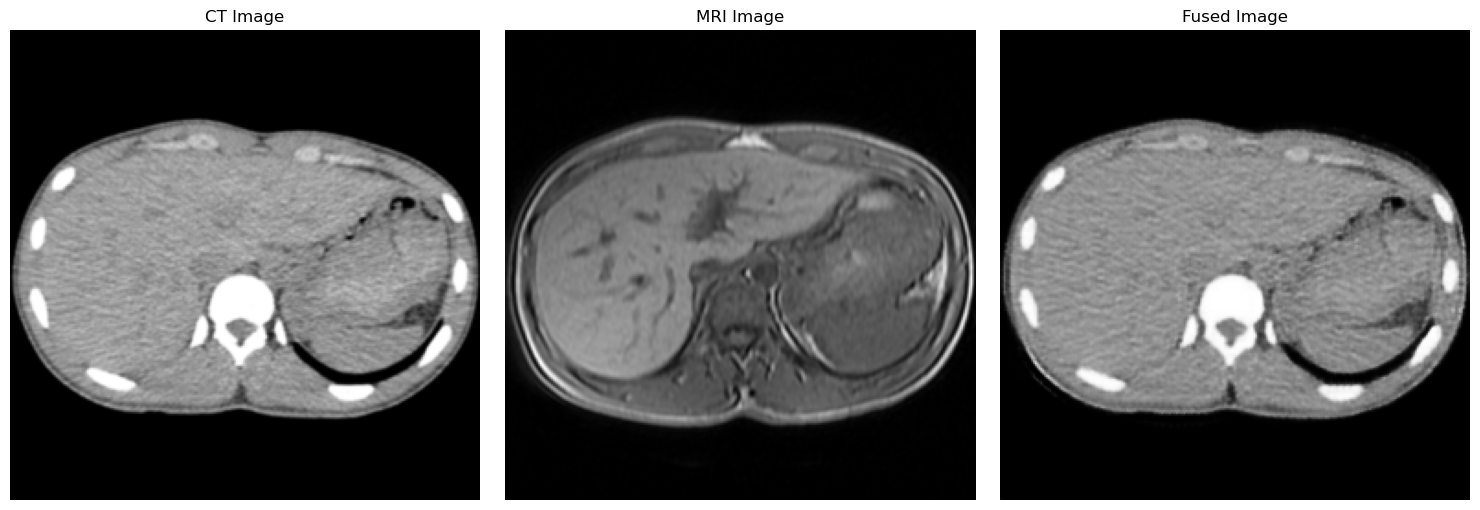

Demonstration completed! Image saved as 'results/ddcgan_fusion/test_demonstration.png'
Demonstration and testing complete!


In [7]:
print("Setting up demonstration and testing...")

def load_test_image_pair():
    """Load a sample CT and MRI image pair for testing"""
    # Create a simple test dataset
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    
    try:
        test_dataset = CTMRIDataset(DATASET_PATH, transform=test_transform, img_size=IMG_SIZE)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
        
        # Get one sample
        for ct_img, mri_img in test_loader:
            return ct_img, mri_img
    except:
        # Create dummy data if dataset is not available
        print("Using dummy data for demonstration")
        dummy_ct = torch.rand(1, 1, IMG_SIZE[0], IMG_SIZE[1]) * 2 - 1
        dummy_mri = torch.rand(1, 1, IMG_SIZE[0], IMG_SIZE[1]) * 2 - 1
        return dummy_ct, dummy_mri

def test_model(checkpoint_path=None):
    """Test the trained model on sample images"""
    # Create a simple generator for demonstration if no checkpoint is available
    generator = Generator(in_channels=2, out_channels=1).to(DEVICE)
    
    if checkpoint_path and os.path.exists(checkpoint_path):
        try:
            # Load checkpoint
            checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
            generator.load_state_dict(checkpoint['generator_state_dict'])
            print(f"✓ Loaded model from {checkpoint_path}")
        except Exception as e:
            print(f"✗ Could not load model: {e}")
            print("Using untrained model for demonstration")
    else:
        print("No checkpoint provided. Using untrained model for demonstration.")
    
    # Set to evaluation mode
    generator.eval()
    
    # Load test images
    ct_img, mri_img = load_test_image_pair()
    ct_img = ct_img.to(DEVICE)
    mri_img = mri_img.to(DEVICE)
    
    # Create input by concatenating CT and MRI images
    input_img = torch.cat([ct_img, mri_img], dim=1)
    
    # Generate fused image
    with torch.no_grad():
        fused_img = generator(input_img)
    
    # Denormalize images for display
    ct_img_display = (ct_img.cpu().squeeze() + 1) / 2
    mri_img_display = (mri_img.cpu().squeeze() + 1) / 2
    fused_img_display = (fused_img.cpu().squeeze() + 1) / 2
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(ct_img_display, cmap='gray')
    axes[0].set_title('CT Image')
    axes[0].axis('off')
    
    axes[1].imshow(mri_img_display, cmap='gray')
    axes[1].set_title('MRI Image')
    axes[1].axis('off')
    
    axes[2].imshow(fused_img_display, cmap='gray')
    axes[2].set_title('Fused Image')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/test_demonstration.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Demonstration completed! Image saved as '{RESULTS_DIR}/test_demonstration.png'")

# Check for available checkpoints
checkpoint_files = []
if os.path.exists(CHECKPOINTS_DIR):
    checkpoint_files = [f for f in os.listdir(CHECKPOINTS_DIR) if f.endswith('.pth')]
if os.path.exists(FINAL_MODELS_DIR):
    checkpoint_files.extend([f for f in os.listdir(FINAL_MODELS_DIR) if f.endswith('.pth')])

if checkpoint_files:
    # Use the latest checkpoint
    checkpoint_files.sort()
    latest_checkpoint = os.path.join(CHECKPOINTS_DIR if checkpoint_files[-1] in os.listdir(CHECKPOINTS_DIR) else FINAL_MODELS_DIR, 
                                    checkpoint_files[-1])
    print(f"Found checkpoint: {latest_checkpoint}")
    test_model(latest_checkpoint)
else:
    print("No checkpoints found. Running demonstration with untrained model.")
    test_model()

print("Demonstration and testing complete!")